# Visualization of Performance Benchmarks

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

In [2]:
def transform_time_to_ratio(df):
    # get baseline runtime, the smallest runtime for the formula.
    m = df.groupby('formula')['time'].min().rename('min_time').reset_index()
    df = df.merge(m, on='formula', how='left')
    # normalize the runtime by the baseline runtime.
    df['time'] = df['time'] / df['min_time']
    return df

In [3]:
REPORT_RATIO = False
if REPORT_RATIO:
    Y_LABEL = "Time as a ratio to the baseline (lower is better)"
else:
    Y_LABEL = "Time (seconds)"

In [4]:
def parse_r_formula(formula):
    # convert r formula to the python formula.
    # if re.compile("choice ~ 0 | user_latent_0 * | 0").match(formula) is not None:
    if "user_latent_0" in formula and "item_latent_0" not in formula:
        return "(user_latents|item)"
    # elif re.compile("choice ~ item_latent_0 * | 0 | 0").match(formula) is not None and formula.endswith("| 0 | 0"):
    elif "item_latent_0" in formula and "user_latent_0" not in formula:
        return "(item_latents|constant)"
    # elif re.compile("choice ~ item_latent_0 * | user_latent_0 * | 0").match(formula) is not None:
    elif "user_latent_0" in formula and "item_latent_0" in formula:
        return "(user_latents|item) + (item_latents|constant)"
    else:
        raise ValueError("Unknown formula: {}".format(formula))

# Performance by Number of Records ($N$)
## R/Python Comparison

In [5]:
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.loc"] = "upper left"
plt.rcParams["figure.dpi"] = 300

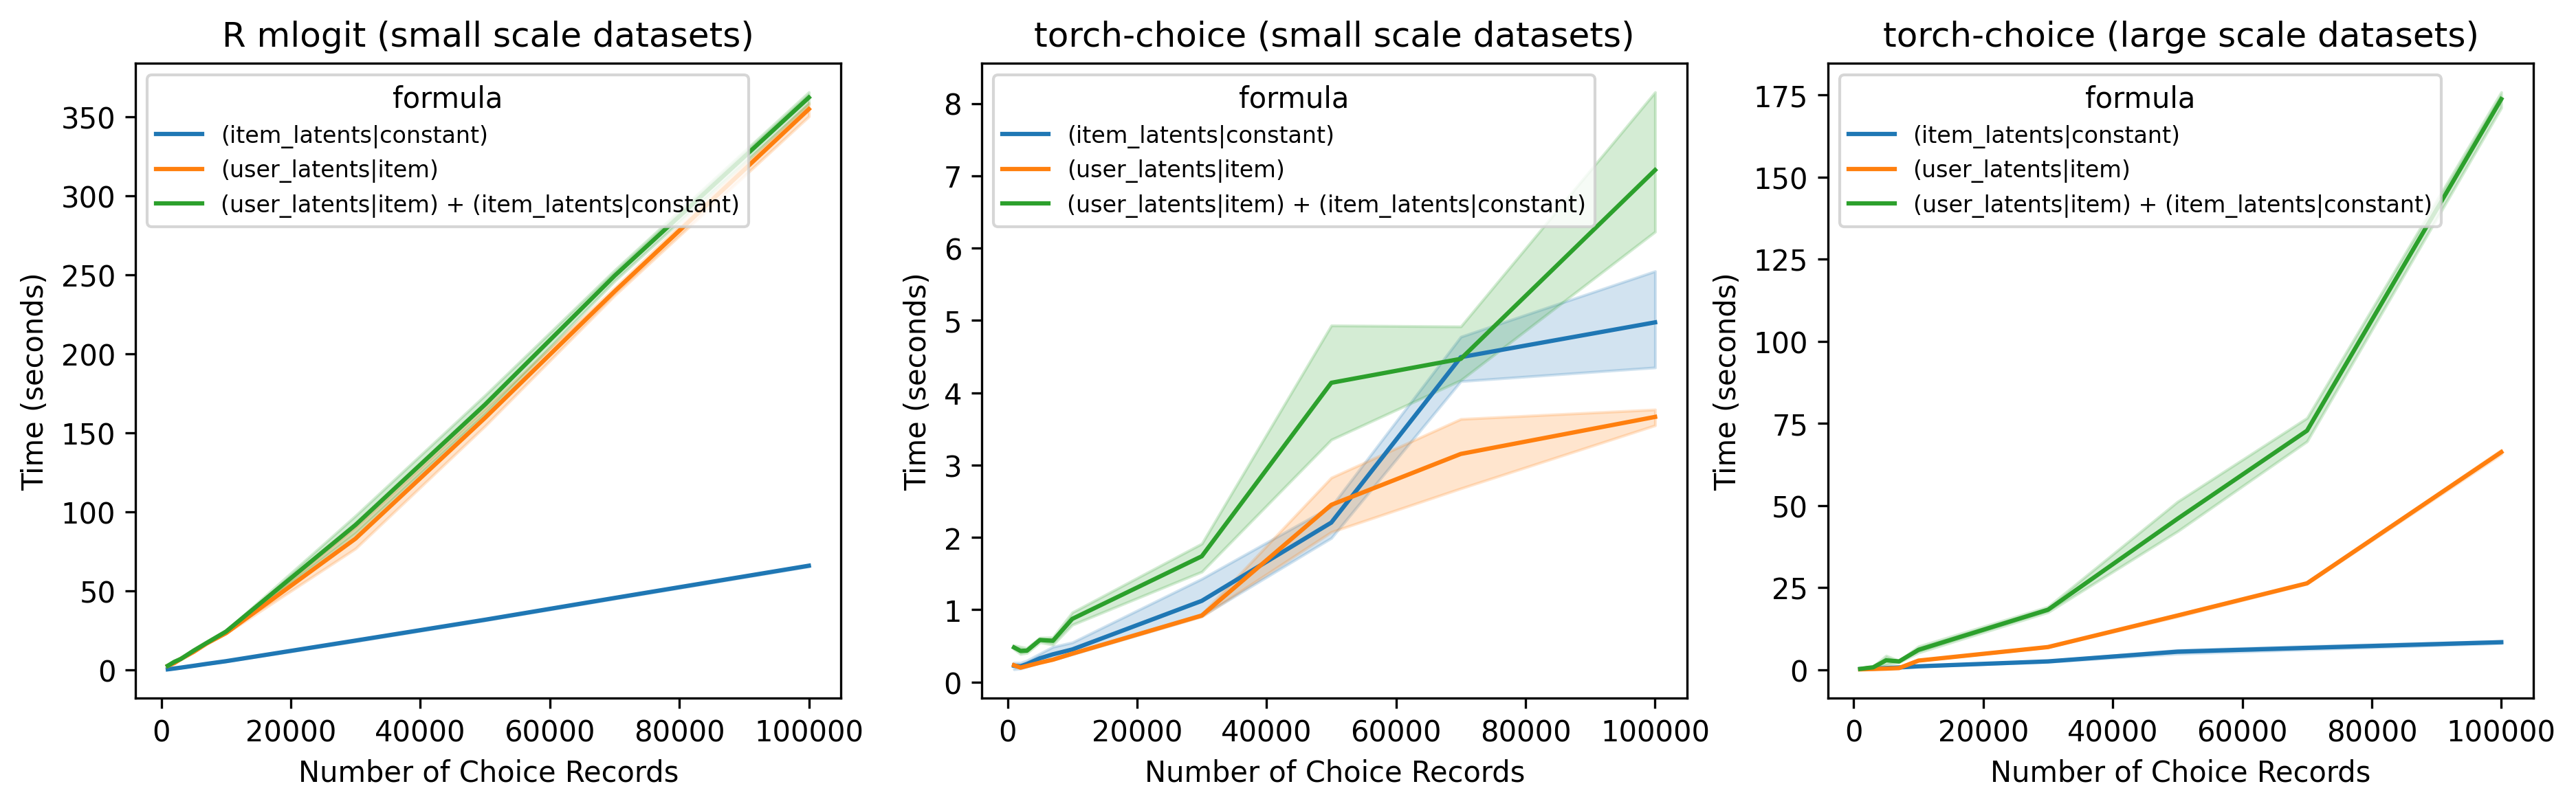

In [6]:
df_r = pd.read_csv("R_performance_num_records.csv")
df_r["package"] = "R"
df_python = pd.read_csv("Python_num_records_experiment_small.csv").rename(columns={"sample_size": "num_records"}).query("num_records <= 100000")
df_python["package"] = "Python"
if REPORT_RATIO:
    df_r = transform_time_to_ratio(df_r)
    df_python = transform_time_to_ratio(df_python)

df_r["formula"] = df_r["formula"].apply(parse_r_formula)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=300)
for i in range(3):
    axes[i].set_xlabel("Number of Choice Records")
    axes[i].set_ylabel(Y_LABEL)

axes[0].set_title("R mlogit (small scale datasets)")
axes[1].set_title("torch-choice (small scale datasets)")
axes[2].set_title("torch-choice (large scale datasets)")

sns.lineplot(x="num_records", y="time", hue="formula", data=df_r.sort_values(by="formula"), ax=axes[0])
sns.lineplot(x="num_records", y="time", hue="formula", data=df_python.sort_values(by="formula"), ax=axes[1])

df = pd.read_csv("Python_num_records_experiment_large.csv").rename(columns={"sample_size": "num_records"}).query("num_records <= 100000")
if REPORT_RATIO:
    df = transform_time_to_ratio(df)
sns.lineplot(x="num_records", y="time", hue="formula", data=df.sort_values(by="formula"), ax=axes[2])
fig.savefig("./figures/num_record_comparisons.png", bbox_inches="tight")

## Further Scale Up Sample Size($N$)

In [7]:
# df = pd.read_csv("Python_num_records_experiment_large.csv").rename(columns={"sample_size": "num_records"}).query("num_records <= 100000")
# if REPORT_RATIO:
#     df = transform_time_to_ratio(df)
# fig, ax = plt.subplots(figsize=(4, 3))
# sns.lineplot(x="num_records", y="time", hue="formula", data=df.sort_values(by="formula"), ax=ax)
# ax.set_ylabel(Y_LABEL)
# ax.set_xlabel("Number of Observations")
# fig.savefig("./figures/num_records_scale.png", bbox_inches="tight")

# Performance by Number of Features ($P$)
## Comparison

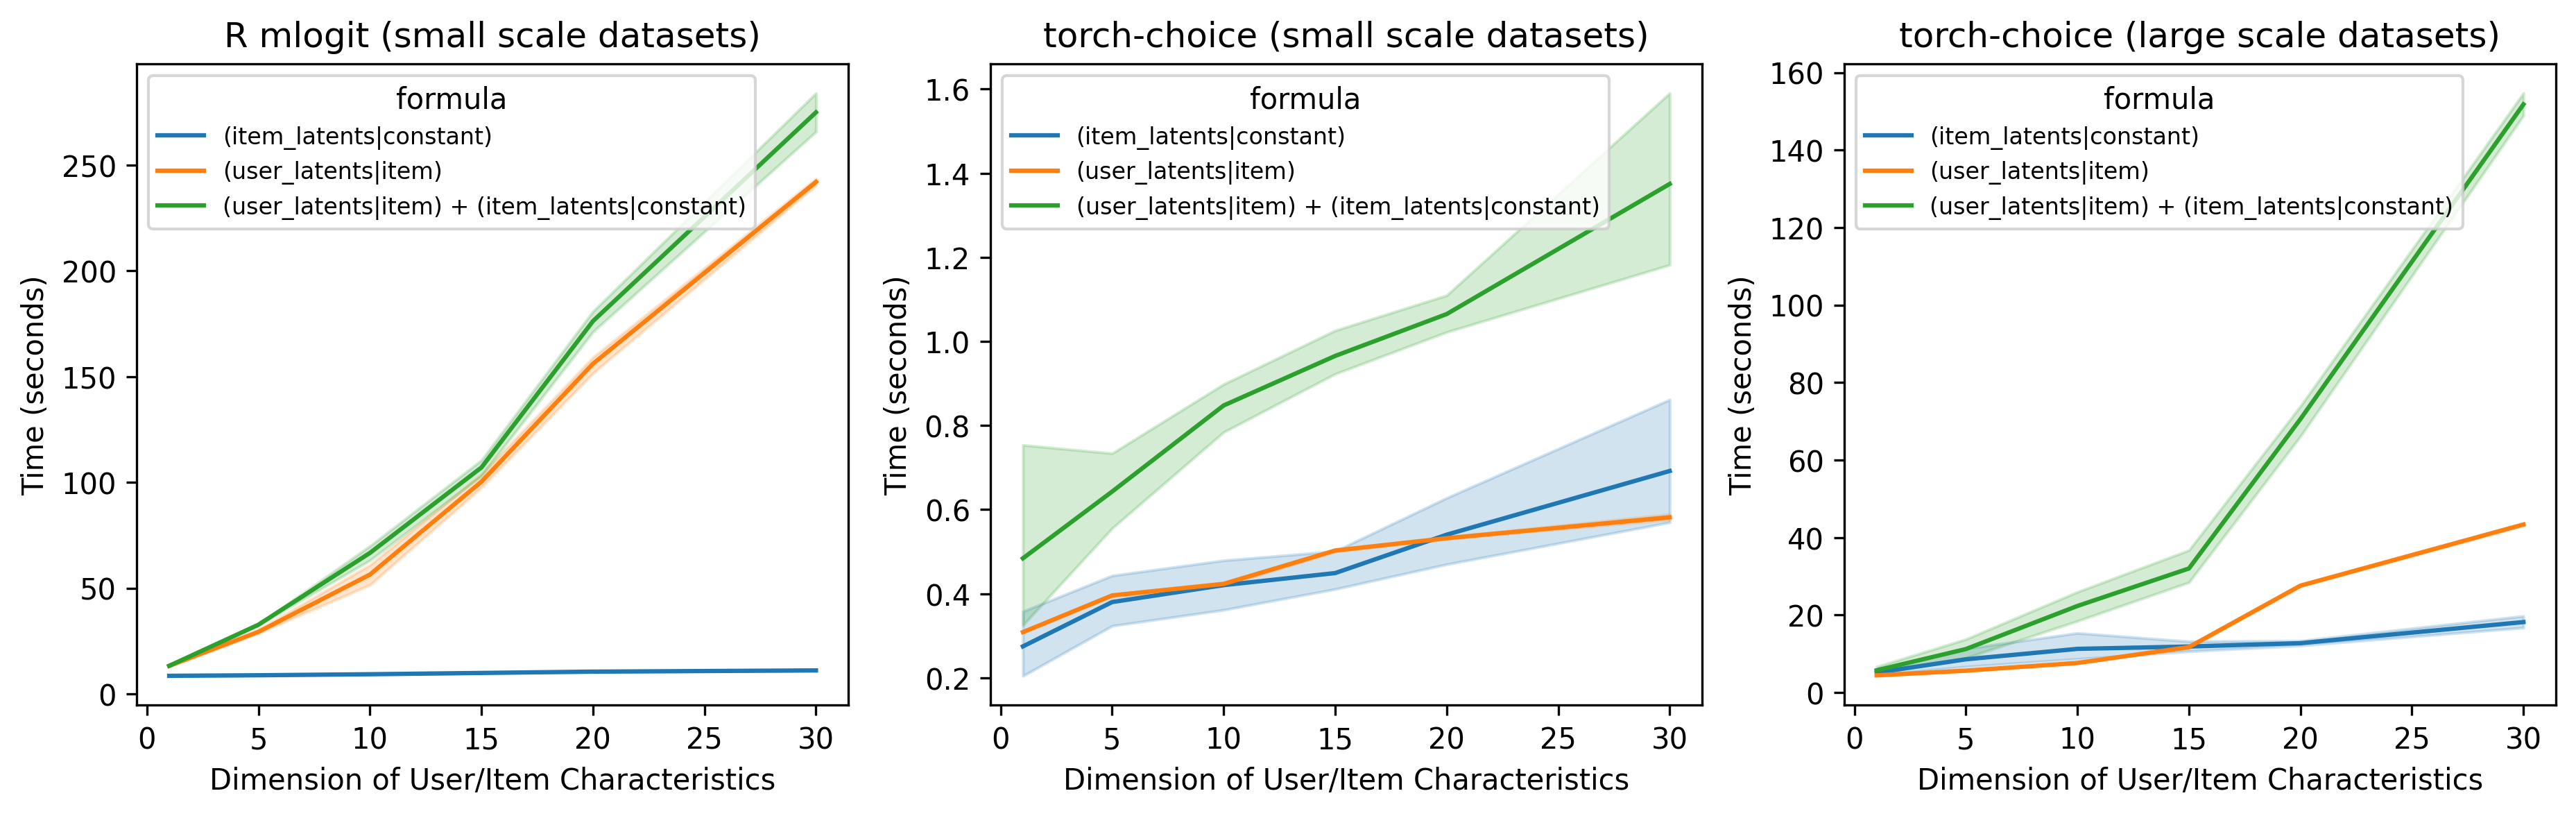

In [9]:
df_r = pd.read_csv("R_performance_num_params.csv")
df_r["package"] = "R"
df_python = pd.read_csv("Python_num_params_experiment_small.csv")
df_python["package"] = "Python"

df_r["formula"] = df_r["formula"].apply(parse_r_formula)
if REPORT_RATIO:
    df_r = transform_time_to_ratio(df_r)
    df_python = transform_time_to_ratio(df_python)
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.lineplot(x="num_params", y="time", hue="formula", data=df_r.sort_values(by="formula"), ax=axes[0])
sns.lineplot(x="num_params", y="time", hue="formula", data=df_python.sort_values(by="formula"), ax=axes[1])


for i in range(3):
    axes[i].set_xlabel("Dimension of User/Item Characteristics")
    axes[i].set_ylabel(Y_LABEL)
axes[0].set_title("R mlogit (small scale datasets)")
axes[1].set_title("torch-choice (small scale datasets)")
axes[2].set_title("torch-choice (large scale datasets)")

df = pd.read_csv("Python_num_params_experiment_large.csv")
if REPORT_RATIO:
    df = transform_time_to_ratio(df)

sns.lineplot(x="num_params", y="time", hue="formula", data=df.sort_values(by="formula"), ax=axes[2])
fig.savefig("./figures/num_covariates_comparisons.png", bbox_inches="tight")

In [10]:
df[df["formula"] == "(user_latents|item)"]

,sample_size,time,formula,num_params,seed
6,200000,4.652190,(user_latents|item),1,0
7,200000,5.500622,(user_latents|item),5,0
8,200000,7.653600,(user_latents|item),10,0
9,200000,11.400735,(user_latents|item),15,0
10,200000,27.769724,(user_latents|item),20,0
11,200000,42.882626,(user_latents|item),30,0
24,200000,4.128687,(user_latents|item),1,1
25,200000,5.748210,(user_latents|item),5,1
26,200000,7.665193,(user_latents|item),10,1
27,200000,11.471692,(user_latents|item),15,1


## Further Scale Up Number of Features ($P$)

In [9]:
# df = pd.read_csv("Python_num_params_experiment_large.csv")
# if REPORT_RATIO:
#     df = transform_time_to_ratio(df)
# fig, ax = plt.subplots(figsize=(4, 3))
# sns.lineplot(x="num_params", y="time", hue="formula", data=df.sort_values(by="formula"), ax=ax)
# ax.set_ylabel(Y_LABEL)
# ax.set_xlabel("Dimension of User/Item Characteristics")
# fig.savefig("./figures/num_params_scale.png", bbox_inches="tight")

# Performance by Number of Items ($I$)
## Comparison

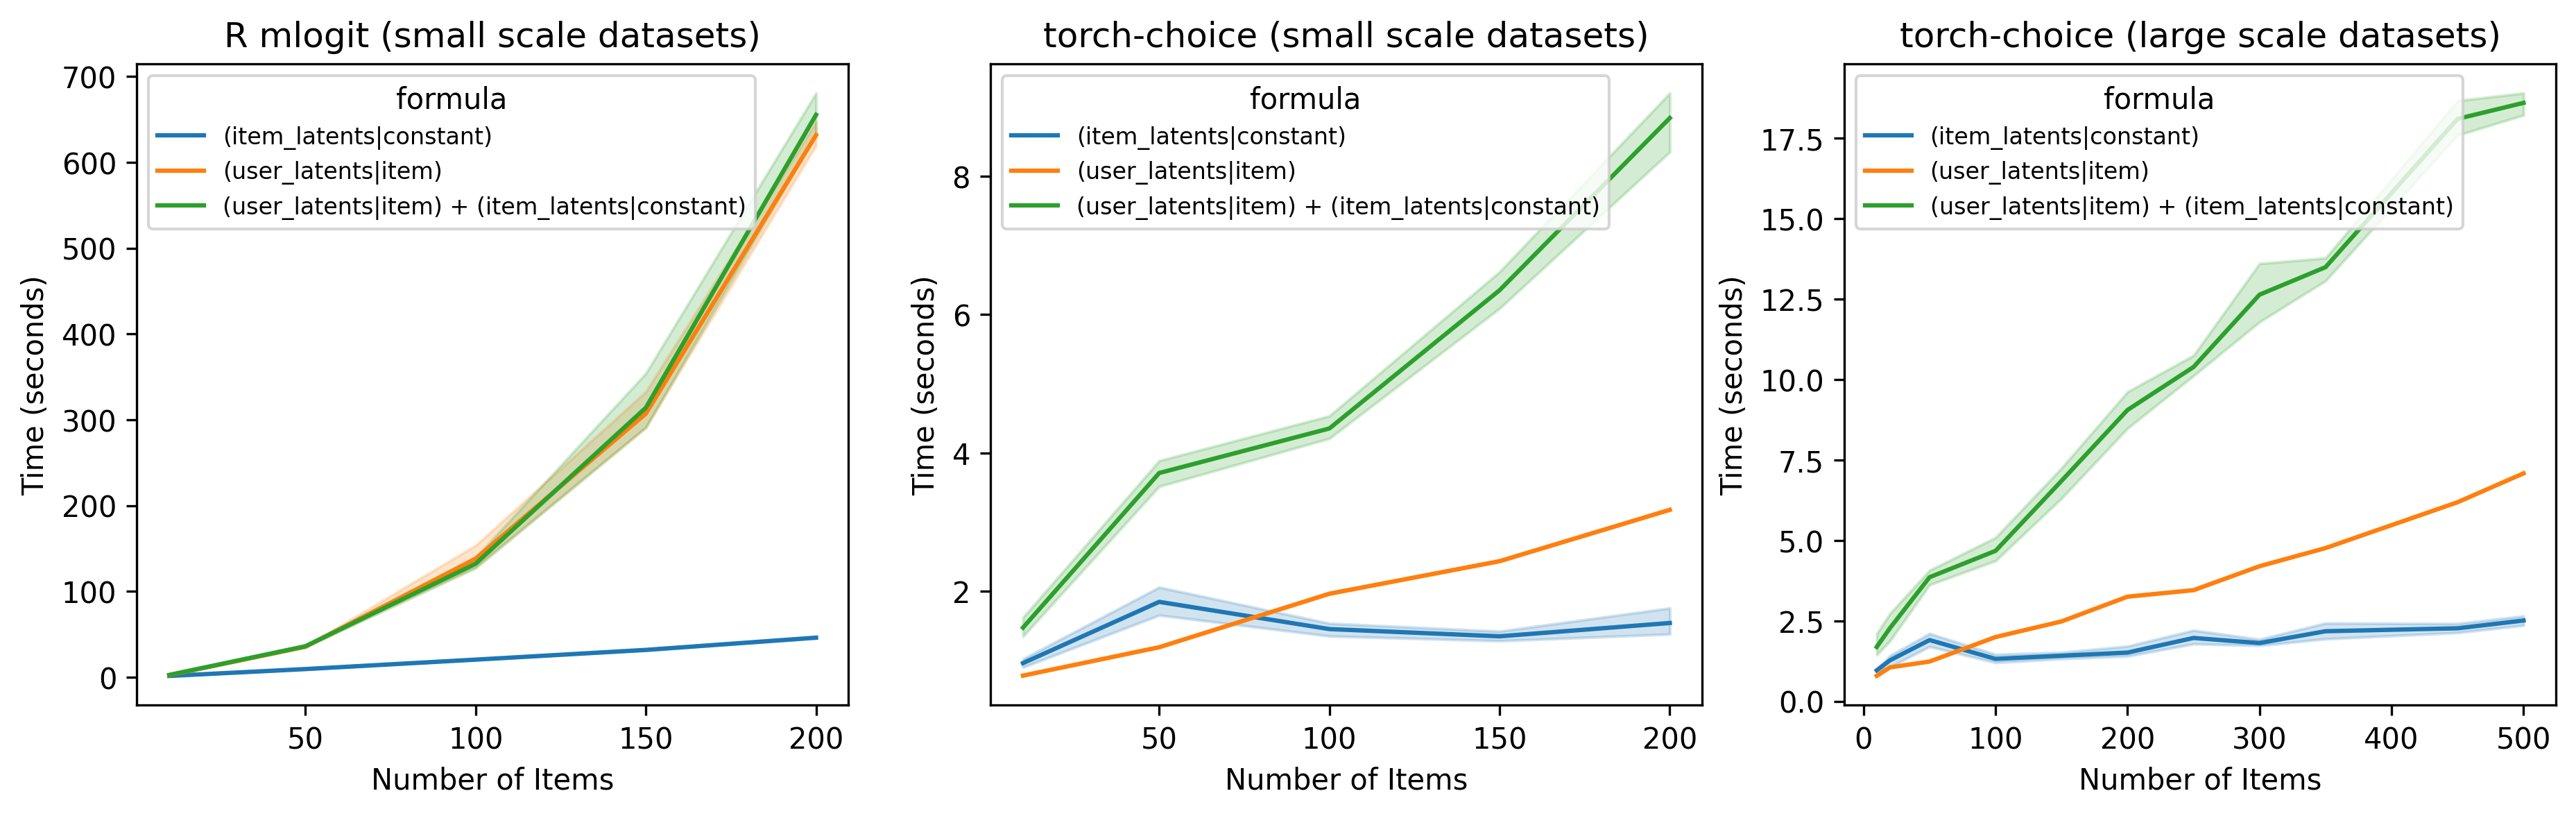

In [10]:
df_r = pd.read_csv("R_performance_num_items.csv").query("num_items != 30")
df_r["package"] = "R"
df_python = pd.read_csv("Python_num_items_experiment_small.csv").query("num_items != 30")
df_python["package"] = "Python"

df_r["r_formula"] = df_r["formula"]
df_r["formula"] = df_r["formula"].apply(parse_r_formula)

if REPORT_RATIO:
    df_r = transform_time_to_ratio(df_r)
    df_python = transform_time_to_ratio(df_python)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.lineplot(x="num_items", y="time", hue="formula", data=df_r.sort_values(by="formula"), ax=axes[0])
sns.lineplot(x="num_items", y="time", hue="formula", data=df_python.sort_values(by="formula"), ax=axes[1])
axes[0].set_title("R")
axes[1].set_title("torch-choice")

for i in range(3):
    axes[i].set_xlabel("Number of Items")
    axes[i].set_ylabel(Y_LABEL)


df = pd.read_csv("Python_num_items_experiment_large.csv").query("num_items != 30 and num_items != 400")
if REPORT_RATIO:
    df = transform_time_to_ratio(df)

sns.lineplot(x="num_items", y="time", hue="formula", data=df.sort_values(by="formula"), ax=axes[2])

axes[0].set_title("R mlogit (small scale datasets)")
axes[1].set_title("torch-choice (small scale datasets)")
axes[2].set_title("torch-choice (large scale datasets)")

fig.savefig('./figures/num_items_comparisons.png', bbox_inches='tight')